## Predicting Opening Price for the next day

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# insert appropriate file path for the dataset in pd.read_excel('')
stock_data = pd.read_excel("BHARTIARTL_NS.csv", index_col='Date')
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-04-02,344.615295,344.615295,332.288757,334.653076,315.101532,2170632.0
2007-04-03,335.135101,340.276917,332.793762,336.833740,317.154755,2225606.0
2007-04-04,341.791901,346.130280,339.771912,343.169159,323.120026,1581013.0
2007-04-05,339.680084,346.566437,339.266907,342.503479,322.493256,1177289.0
2007-04-09,343.834839,351.662323,342.044403,349.389832,328.977295,1821341.0


In [ ]:
stock_data.index

DatetimeIndex(['2007-04-02', '2007-04-03', '2007-04-04', '2007-04-05',
               '2007-04-09', '2007-04-10', '2007-04-11', '2007-04-12',
               '2007-04-13', '2007-04-16',
               ...
               '2022-03-16', '2022-03-17', '2022-03-21', '2022-03-22',
               '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-28',
               '2022-03-29', '2022-03-30'],
              dtype='datetime64[ns]', name='Date', length=3705, freq=None)

In [ ]:
stock_data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [ ]:
stock_data.isna().any()

Open         True
High         True
Low          True
Close        True
Adj Close    True
Volume       True
dtype: bool

In [ ]:
stock_data = stock_data.fillna(stock_data.mean())

In [ ]:
stock_data.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [ ]:
data = stock_data.iloc[:, :5]
data.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2007-04-02,344.615295,344.615295,332.288757,334.653076,315.101532
2007-04-03,335.135101,340.276917,332.793762,336.833740,317.154755
2007-04-04,341.791901,346.130280,339.771912,343.169159,323.120026
2007-04-05,339.680084,346.566437,339.266907,342.503479,322.493256
2007-04-09,343.834839,351.662323,342.044403,349.389832,328.977295


In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.values)
data_scaled = pd.DataFrame(columns=data.columns, data=data_scaled, index=data.index)
data_scaled.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2007-04-02,-0.232199,-0.285372,-0.291142,-0.324048,-0.391436
2007-04-03,-0.323898,-0.326827,-0.286190,-0.302908,-0.372159
2007-04-04,-0.259509,-0.270896,-0.217771,-0.241490,-0.316154
2007-04-05,-0.279936,-0.266728,-0.222723,-0.247943,-0.322038
2007-04-09,-0.239748,-0.218035,-0.195490,-0.181185,-0.261163


In [ ]:
scaler_target = StandardScaler()
scaler_target.fit_transform(data.iloc[:, 0:1])

array([[-0.23219932],
       [-0.32389784],
       [-0.259509  ],
       ...,
       [ 3.35281731],
       [ 3.59608447],
       [ 3.81226778]])

In [ ]:
train_split = 0.80
split_idx = int(np.ceil(len(data_scaled)*train_split))
train_data, test_data = data_scaled[:split_idx], data_scaled[split_idx:]

In [ ]:
train_data.shape, test_data.shape

((2964, 5), (741, 5))

In [ ]:
# training of an LSTM model requires a window/timestep of data in each training 
# step(e.g. LSTM may take 9 data samples to predict the 10th one by weighing 
# the first nine input samples in one step)

In [ ]:
def create_dataset(dataset, time_step=1):
    X_data, y_data = [], []
    for i in range(len(dataset)-time_step-1):
        X_data.append(dataset.iloc[i:i+time_step,:])
        y_data.append(dataset.iloc[i+time_step,0])

    return np.array(X_data), np.array(y_data)

In [ ]:
window = 10
X_train, y_train = create_dataset(train_data, window)
X_test, y_test = create_dataset(test_data, window)

In [ ]:
X_train.shape, y_train.shape

((2953, 10, 5), (2953,))

In [ ]:
X_test.shape, y_test.shape

((730, 10, 5), (730,))

In [ ]:
model = Sequential()

model.add(LSTM(50, input_shape=X_train.shape[1:], return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(50))

model.add(Dropout(0.2))

model.add(Dense(1))

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
model.compile(loss='mean_squared_error', optimizer=optim)

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 10, 50)            11200     
                                                                 
 dropout_16 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,451
Trainable params: 31,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=32, verbose=2)

Epoch 1/100
93/93 - 6s - loss: 0.0325 - val_loss: 0.5617 - 6s/epoch - 64ms/step
Epoch 2/100
93/93 - 1s - loss: 0.0182 - val_loss: 0.3061 - 1s/epoch - 11ms/step
Epoch 3/100
93/93 - 1s - loss: 0.0156 - val_loss: 0.2418 - 983ms/epoch - 11ms/step
Epoch 4/100
93/93 - 1s - loss: 0.0143 - val_loss: 0.0993 - 932ms/epoch - 10ms/step
Epoch 5/100
93/93 - 1s - loss: 0.0129 - val_loss: 0.1611 - 1s/epoch - 11ms/step
Epoch 6/100
93/93 - 1s - loss: 0.0124 - val_loss: 0.1012 - 928ms/epoch - 10ms/step
Epoch 7/100
93/93 - 1s - loss: 0.0119 - val_loss: 0.1644 - 953ms/epoch - 10ms/step
Epoch 8/100
93/93 - 1s - loss: 0.0104 - val_loss: 0.1396 - 970ms/epoch - 10ms/step
Epoch 9/100
93/93 - 1s - loss: 0.0112 - val_loss: 0.0495 - 949ms/epoch - 10ms/step
Epoch 10/100
93/93 - 1s - loss: 0.0100 - val_loss: 0.0533 - 933ms/epoch - 10ms/step
Epoch 11/100
93/93 - 1s - loss: 0.0096 - val_loss: 0.0629 - 975ms/epoch - 10ms/step
Epoch 12/100
93/93 - 1s - loss: 0.0099 - val_loss: 0.0655 - 1s/epoch - 16ms/step
Epoch 13/100


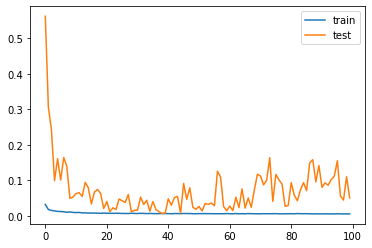

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

23/23 [==============================] - 0s 4ms/step


In [ ]:
# performance metrics
rmse = mean_squared_error(test_pred, y_test, squared=False)
mape = mean_absolute_percentage_error(test_pred, y_test)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 0.2253533008686469
MAPE: 0.20787977151051082


In [ ]:
train_pred.shape, test_pred.shape 

((2953, 1), (730, 1))

In [ ]:
# re-scaling the predictions
train_pred = scaler.inverse_transform(
    np.repeat(train_pred, data.shape[1], axis=-1))[:, 0]

test_pred = scaler.inverse_transform(
    np.repeat(test_pred, data.shape[1], axis=-1))[:, 0]